### imports

In [1]:
import json
import pickle
import re
import numpy as np
import pandas as pd
from Datasets import *
from tqdm.notebook import tqdm
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader, RandomSampler
from sklearn.metrics import roc_curve, jaccard_score, accuracy_score
from sklearn.metrics import average_precision_score, coverage_error, label_ranking_average_precision_score, label_ranking_loss, roc_auc_score
import seaborn as sns
from models import PreBuildConverter
from functools import partial
from CKA_torch import CkaLoss
import os
import matplotlib.pylab as plt
import matplotlib
from itertools import combinations
%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### loading dataset and models 

In [2]:
model_dir = 'work_space/save/CheXpert'

In [3]:
# paren are probes
chexpert_paren = {
    'No_finding': 1,
    'parenchymal': 1,
    'extraparenchymal': 0,
    'limit_out_labels': 1,
    'with_rank':True,
    'with_path':True
}
                  
train, test, in_out, out_out = get_chexpert(**chexpert_paren)
dloader_args = {
        'batch_size': 50,
        'pin_memory': False,
        'num_workers': 0,
        'drop_last': False,
}

train_sampler = RandomSampler(train, replacement=True, num_samples=len(train))
train = DataLoader(train, sampler=train_sampler, **dloader_args)

eval_sampler = RandomSampler(test, replacement=True, num_samples=len(test))
test = DataLoader(test, sampler=eval_sampler, **dloader_args)

in_out_sampler = RandomSampler(in_out, replacement=True, num_samples=len(in_out)//10)
in_out = DataLoader(in_out, sampler=in_out_sampler, **dloader_args)

out_out_sampler = RandomSampler(out_out, replacement=True, num_samples=len(out_out))
out_out = DataLoader(out_out, sampler=out_out_sampler, **dloader_args)

In [41]:
pd.Series(train.dataset.rank_labels.numpy()).value_counts(normalize=True)

0    0.318886
5    0.170350
4    0.140720
3    0.135686
6    0.102699
1    0.065925
2    0.065733
dtype: float64

In [40]:
pd.Series(test.dataset.rank_labels.numpy()).value_counts(normalize=True)

0    0.312425
5    0.169975
4    0.145740
3    0.140257
6    0.106700
1    0.065906
2    0.058998
dtype: float64

In [45]:
build_model = PreBuildConverter(in_channels=3, out_classes=len(test.dataset.label_names),
                                    add_rank=True, pretrained=False)
model = build_model.get_by_str('densenet121')

In [46]:
model

DenseRankHead(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

### calc emmbeddings

In [4]:
def load_fix(target_path):
    a = torch.load(target_path)#, map_location=lambda storage, loc: storage.cuda())
    fixed_a = {k.split('module.')[-1]: a[k] for k in a}
    torch.save(fixed_a, target_path)

def get_model(target_path):
    build_model = PreBuildConverter(in_channels=3, out_classes=len(test.dataset.label_names),
                                    add_rank=True, pretrained=False)

    model = build_model.get_by_str('densenet121')
    load_fix(target_path)
    model.load_state_dict(torch.load(target_path))
    model.train(mode=False)
    return model

def make_scores_pair(model_paths, loader, train=False, layer='class', rank=False):
    models = [get_model(model).to('cuda') for model in model_paths] # #
    thetas = [[] for i in range(len(model_paths))]
    rank_thetas = [[] for i in range(len(model_paths))]
    labels = []
    rank_labels = []
    cka_class_loss = CkaLoss(models, ['classifier_rank_2'])
    cka_class_losses = []
    paths = []
    for imgs, label, path in tqdm(loader, total=len(loader)):
        for i,model in enumerate(models):
            theta, rank_theta = model(imgs.cuda())
            rank_thetas[i].append(rank_theta.detach().cpu().numpy())
            thetas[i].append(theta.detach().cpu().numpy())
        if rank:
            label, rank_label = label
            rank_labels.append(rank_label.cpu().numpy())
        labels.append(label.cpu().numpy())
        cka_class_losses.append(cka_class_loss().detach().cpu().numpy().item())
        paths.append(path)
        
    for model in models: del model
    torch.cuda.empty_cache()
    
    paths = np.concatenate(paths)
    labels = np.concatenate(labels)
    rank_labels = [] if not rank else np.concatenate(rank_labels)
    cka_class_losses = np.array(cka_class_losses)
    thetas = [np.concatenate(x) for x in thetas]
    rank_thetas = [np.concatenate(x) for x in rank_thetas]
    
    return thetas, labels, rank_thetas, rank_labels, cka_class_losses, paths

### fuser funcs

In [5]:
def thresh_calibration(thetas, labels):
    model_calibration = []
    for i in range(len(thetas)):
        curr_prob = thetas[i]
        curr_thresh = []
        for j in range(curr_prob.shape[1]):
            fpr, tpr, thresholds = roc_curve(labels[:, j], curr_prob[:, j])
            optimal_idx = np.argmax(tpr - fpr)
            curr_thresh.append(thresholds[optimal_idx])
        model_calibration.append(curr_thresh)
    return model_calibration

def thresh_fuser(mat_a, mat_b, threshhold_a, threshhold_b):
    return (mat_a >= threshhold_a) & (mat_b >= threshhold_b)

def fuser(thetas, labels, calibration_th, n_classes=7, metric=None):
    labels = labels[:, :n_classes]
    fuse_prediction = thresh_fuser(thetas[0], thetas[1], calibration_th[0], calibration_th[1])
    if metric is None:
        return (fuse_prediction == labels).mean(0)
    else:
        return metric(labels, fuse_prediction)

def fuser_ood(thetas, labels, calibration_th, n_classes=7, metric=None):
    labels = labels[:, :n_classes]
    fuse_prediction = thresh_fuser(thetas[0], thetas[1], calibration_th[0], calibration_th[1])
    if metric is None:
        return (fuse_prediction.sum(1) < 1).mean()
    else:
        metric(labels, fuse_prediction)

### model estimators

In [6]:
def get_model_performance(use_model):
    print(use_model)
    use_model = [os.path.join(use_model, model_path) for model_path in 
               os.listdir(use_model) if 'model' in model_path]
    
    model_in_out_res = make_scores_pair(use_model, in_out, train=True)
    model_train = make_scores_pair(use_model, train, train=True, rank=True)
    model_test_res = make_scores_pair(use_model, test, train=True, rank=True)
    model_out_res = make_scores_pair(use_model, out_out, train=True)
    
    model_calibration = thresh_calibration(model_train[0], model_train[1])
    test_res = fuser(model_test_res[0], model_test_res[1], model_calibration)
    print(test_res)
    out_res = fuser(model_out_res[0], model_out_res[1], model_calibration)
    print(out_res)
    in_out_res = fuser(model_in_out_res[0], model_in_out_res[1], model_calibration)
    print(in_out_res)
    ood_out = fuser_ood(model_out_res[0], model_out_res[1], model_calibration)
    print(ood_out)
    ood_in = fuser_ood(model_in_out_res[0], model_in_out_res[1], model_calibration)
    print(ood_in)
    res = dict({'train':model_train, 'test':model_test_res, 'in_out':model_in_out_res, 'out':model_out_res,
                'calibration': model_calibration, 'test_res': test_res, 'in_out_res':in_out_res, 'out_res':out_res,
                'ood_out':ood_out, 'ood_in':ood_in
               })
    return res

### load rank models

In [42]:
os.listdir(model_dir +"/Rank")

[]

In [8]:
rank_model_list = [model_dir+'/Rank/'+d for d in os.listdir(model_dir +'/'+"Rank") if '2020-07-13' in d and 'n=2' in d]

In [73]:
l = [8707, 6651, 2597, 1364, 765, 343, 430]
l = [1375, 3553, 2935, 2142, 2830, 6651, 1371]

In [74]:
pd.Series(np.array(l) / sum(l), index=test.dataset.label_names)

No Finding       0.065925
Lung Lesion      0.170350
Lung Opacity     0.140720
Edema            0.102699
Consolidation    0.135686
Pneumonia        0.318886
Atelectasis      0.065733
dtype: float64

In [72]:
pd.Series(np.array(l) / sum(l), index=test.dataset.label_names)

No Finding       0.417462
Lung Lesion      0.318886
Lung Opacity     0.124515
Edema            0.065398
Consolidation    0.036678
Pneumonia        0.016445
Atelectasis      0.020617
dtype: float64

In [10]:
rank_results = {model:get_model_performance(model) for model in rank_model_list}

work_space/save/CheXpert/Rank/2020-07-13_14:04_n=2_densenet121_lr=0.0001_m=_a=0_52_p=False_mean=False_cka=False_pre_pre_layers=-1_pre_steps=100_clean-int-ext=1-1-0_limited=1_rank_alpha=0.25_rank_pearson=0.2



[0.79230179 0.87564426 0.64425924 0.78714771 0.74416054 0.76181599
 0.73308477]
[0.74968815 0.91484407 0.72490644 0.8039501  0.77330561 0.88511435
 0.73621622]
[0.93096779 0.93104218 0.54749684 0.68541248 0.59614669 0.74529495
 0.60440378]
0.1886902286902287
0.09186937439559623
work_space/save/CheXpert/Rank/2020-07-13_14:02_n=2_densenet121_lr=0.0001_m=_a=0_52_p=False_mean=False_cka=False_pre_pre_layers=-1_pre_steps=100_clean-int-ext=1-1-0_limited=1_rank_alpha=0.1_rank_pearson=0.2



[0.79021823 0.92685601 0.63515736 0.79493366 0.79076653 0.80162298
 0.73714223]
[0.72411642 0.98844075 0.76440748 0.87226611 0.91762994 0.95825364
 0.86045738]
[0.91936324 0.94956483 0.50450048 0.69404151 0.70445585 0.83701555
 0.62515807]
0.28848232848232847
0.2044930447072826
work_space/save/CheXpert/Rank/2020-07-13_14:03_n=2_densenet121_lr=0.0001_m=_a=0_52_p=False_mean=False_cka=False_pre_pre_layers=-1_pre_steps=100_clean-int-ext=1-1-0_limited=1_rank_alpha=0.5_rank_pearson=0.2



[0.79570128 0.84439083 0.65050992 0.79581094 0.74723106 0.76521548
 0.72661476]
[0.73318087 0.86536383 0.75841996 0.83347193 0.77222453 0.88744283
 0.74203742]
[0.9277691  0.90344417 0.52584988 0.69456223 0.60708175 0.75570929
 0.60566838]
0.17796257796257797
0.09685338094175407


In [38]:
pickle.dump(rank_results, open('rank_res', 'wb'))
#rank_results = pickle.load(open('rank_res', 'rb'))

In [56]:
pd.DataFrame([res_1, res_0, res_2], index=pd.Index(['0.1', '0.25', '0.5'], name='rank_alpha'), columns=['train', 'test', 'out', 'mix'])

,train,test,out,mix
rank_alpha,,,,
0.1,0.872705,0.589538,0.528441,0.471993
0.25,0.115021,0.113061,0.088898,0.019118
0.5,0.201995,0.184669,0.169023,0.034665


In [49]:
ind = 1
res_1 = []
emba, embb = rank_results[list(rank_results.keys())[ind]]['train'][2]
res_1.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['test'][2]
res_1.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['out'][2]
res_1.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['in_out'][2]
res_1.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
res_1

[0.8727046075658053,
 0.5895383265708959,
 0.5284407484407484,
 0.47199285873688906]

In [50]:
ind = 0
res_0 = []
emba, embb = rank_results[list(rank_results.keys())[ind]]['train'][2]
res_0.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['test'][2]
res_0.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['out'][2]
res_0.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['in_out'][2]
res_0.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
res_0

[0.11502133576257371,
 0.11306064261432175,
 0.0888981288981289,
 0.019117756453172655]

In [51]:
ind = 2
res_2 = []
emba, embb = rank_results[list(rank_results.keys())[ind]]['train'][2]
res_2.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['test'][2]
res_2.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['out'][2]
res_2.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
emba, embb = rank_results[list(rank_results.keys())[ind]]['in_out'][2]
res_2.append((np.argmax(emba, 1) == np.argmax(embb, 1)).mean())
res_2

[0.20199453420913843,
 0.18466937164162736,
 0.16902286902286903,
 0.03466488135088894]

In [34]:
emba, embb = rank_results[list(rank_results.keys())[ind]]['train'][2]

<IPython.core.display.Javascript object>


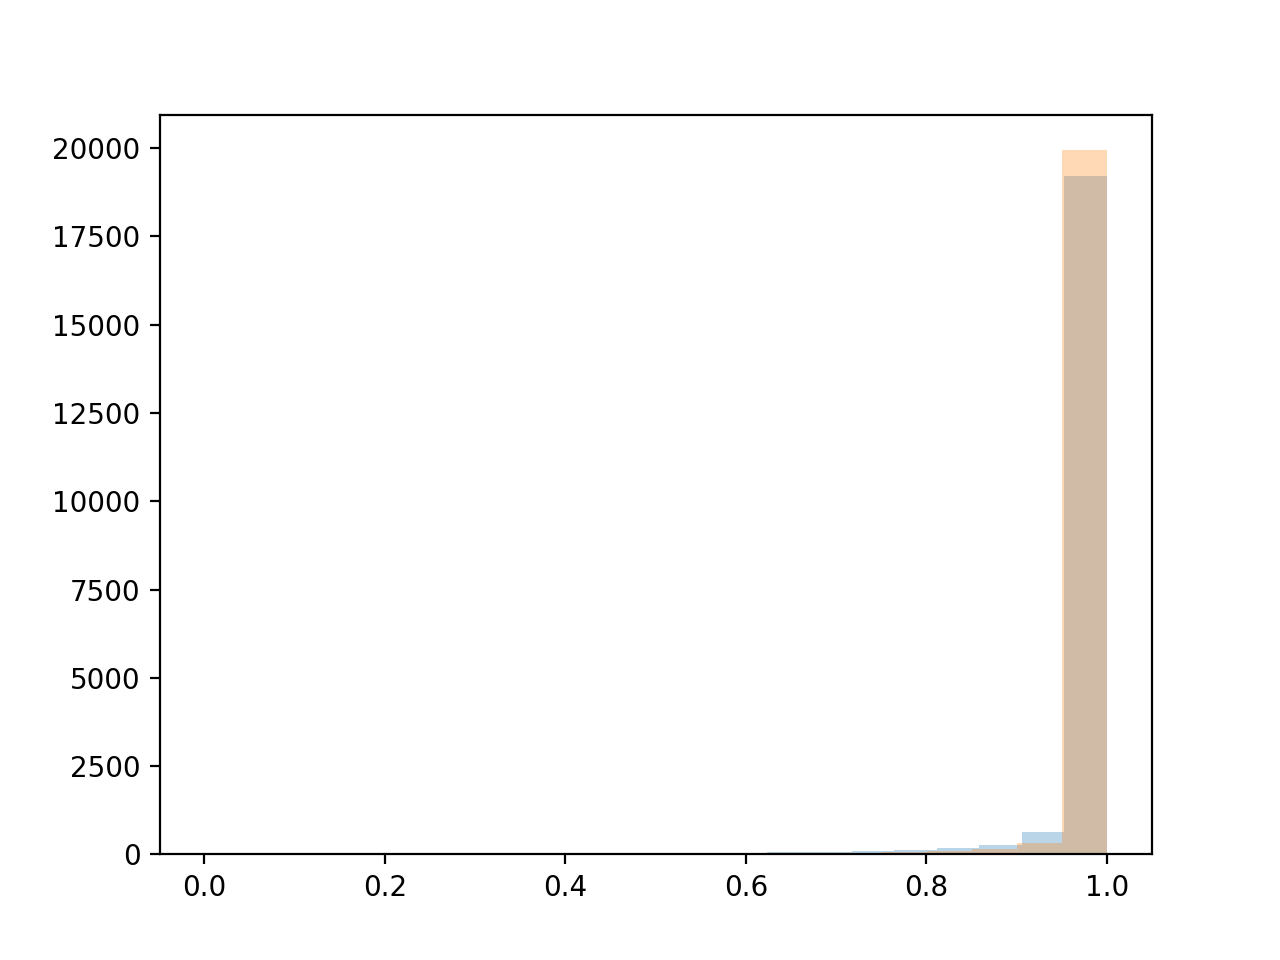

<IPython.core.display.Javascript object>


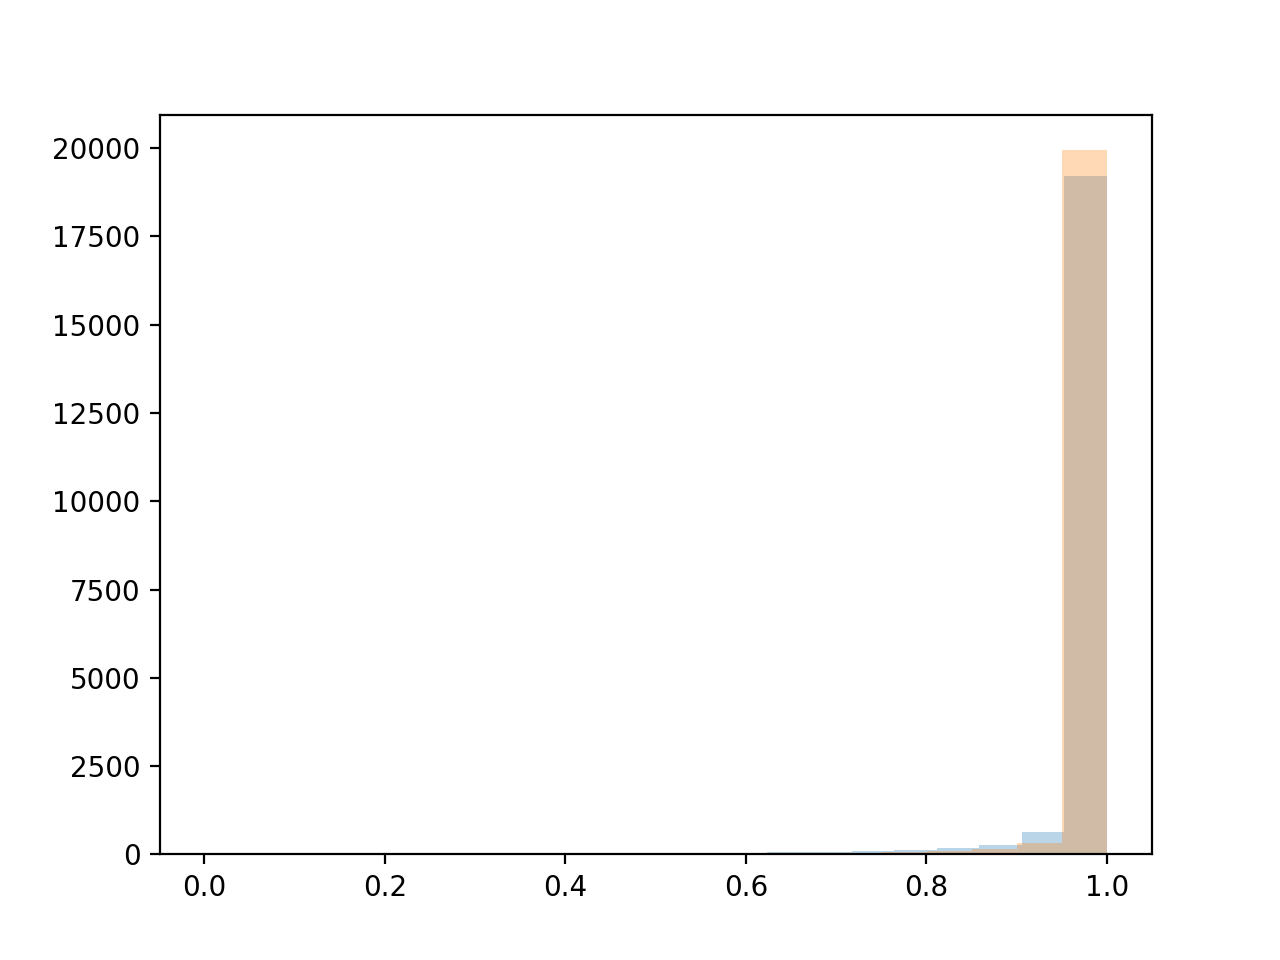

In [63]:
ind = 1
plt.figure()
emba, embb = rank_results[list(rank_results.keys())[ind]]['train'][0]
pd.Series(emba.max(1)).hist(bins=20, grid=False, alpha=0.3)
pd.Series(embb.max(1)).hist(bins=20, grid=False, alpha=0.3) 

<IPython.core.display.Javascript object>


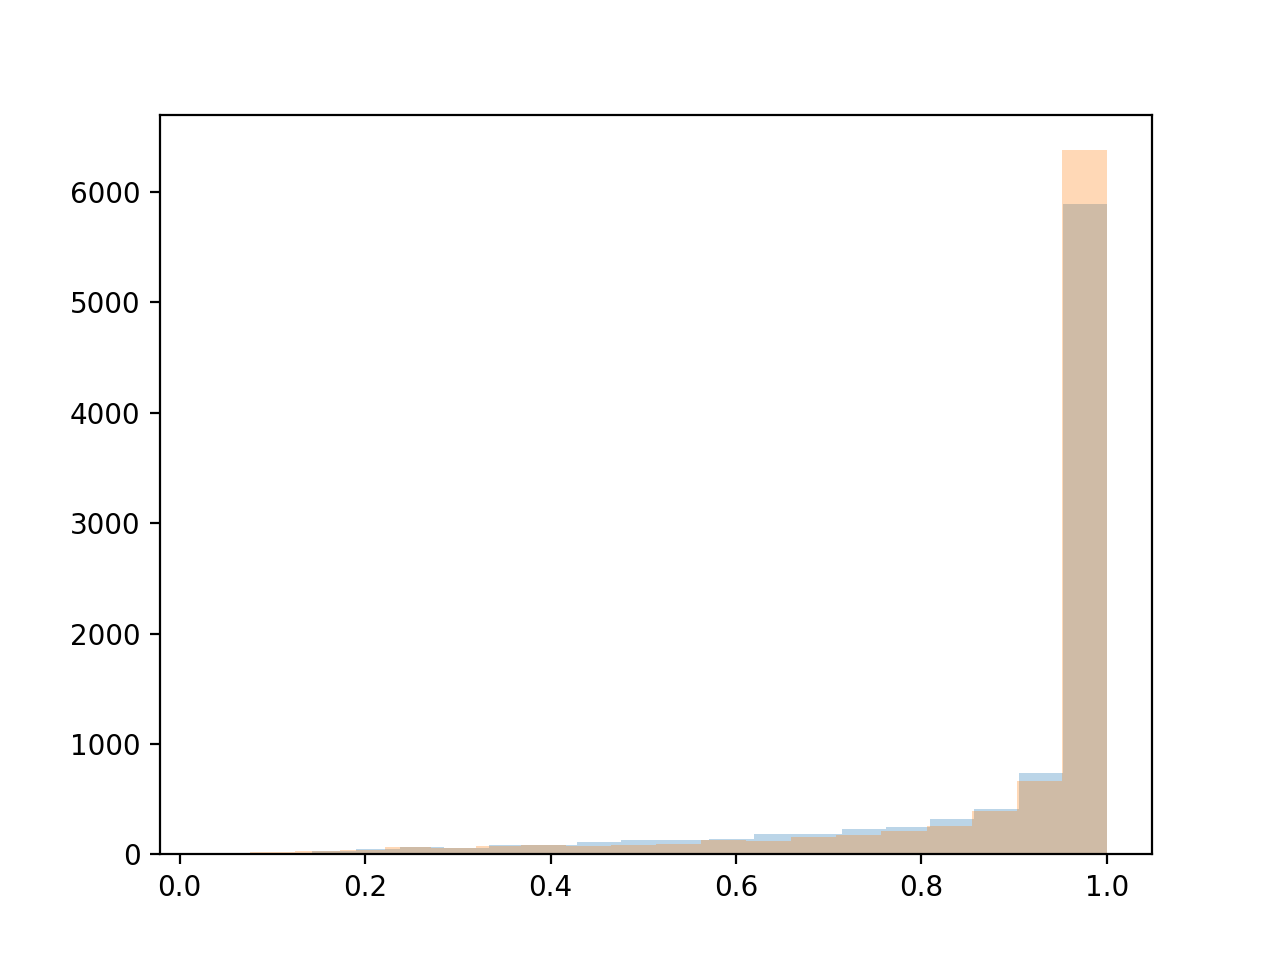

<IPython.core.display.Javascript object>


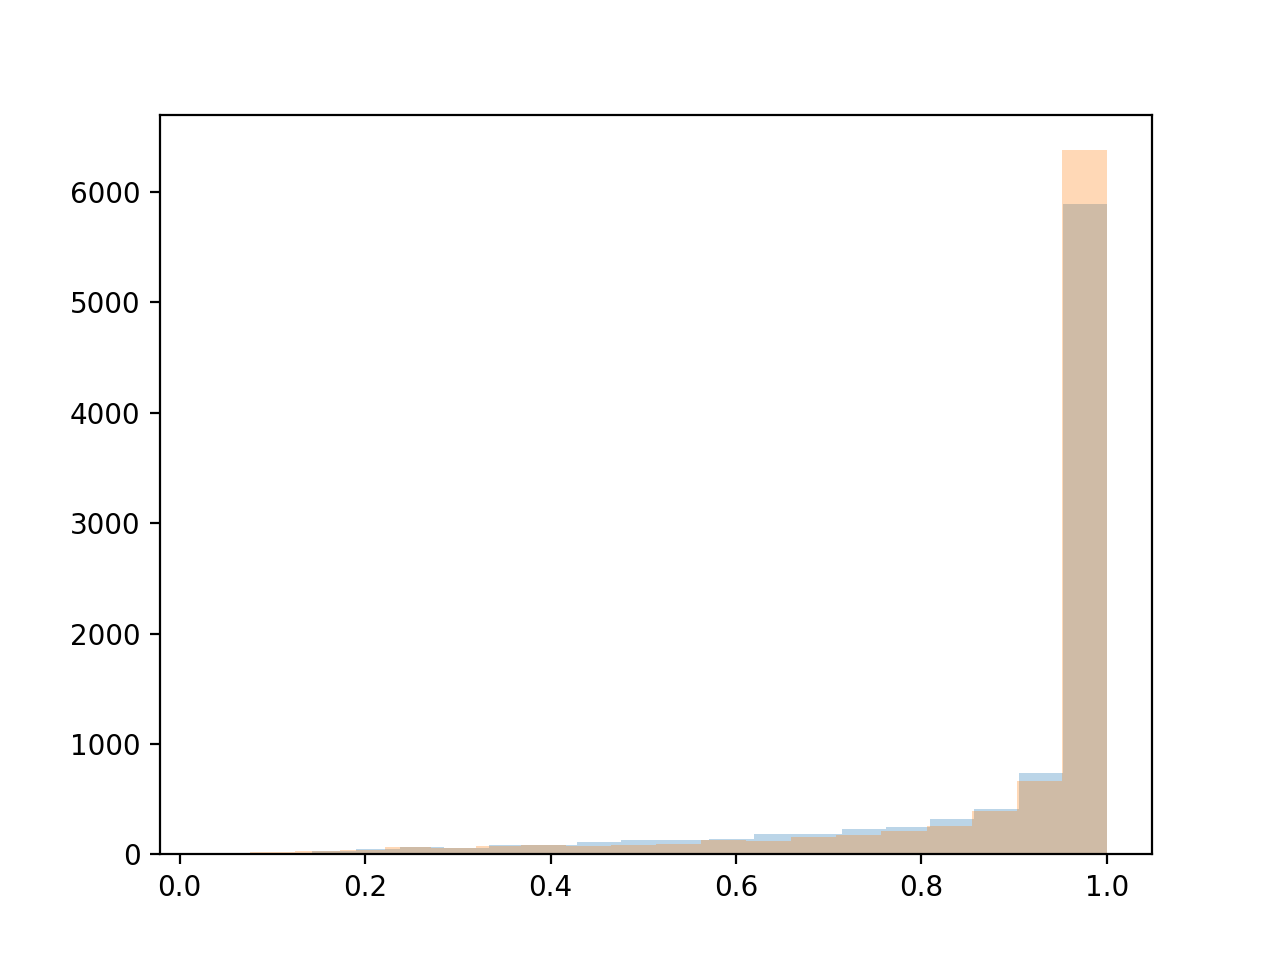

In [64]:
plt.figure()
emba, embb = rank_results[list(rank_results.keys())[ind]]['test'][0]
pd.Series(emba.max(1)).hist(bins=20, grid=False, alpha=0.3)
pd.Series(embb.max(1)).hist(bins=20, grid=False, alpha=0.3) 

<IPython.core.display.Javascript object>


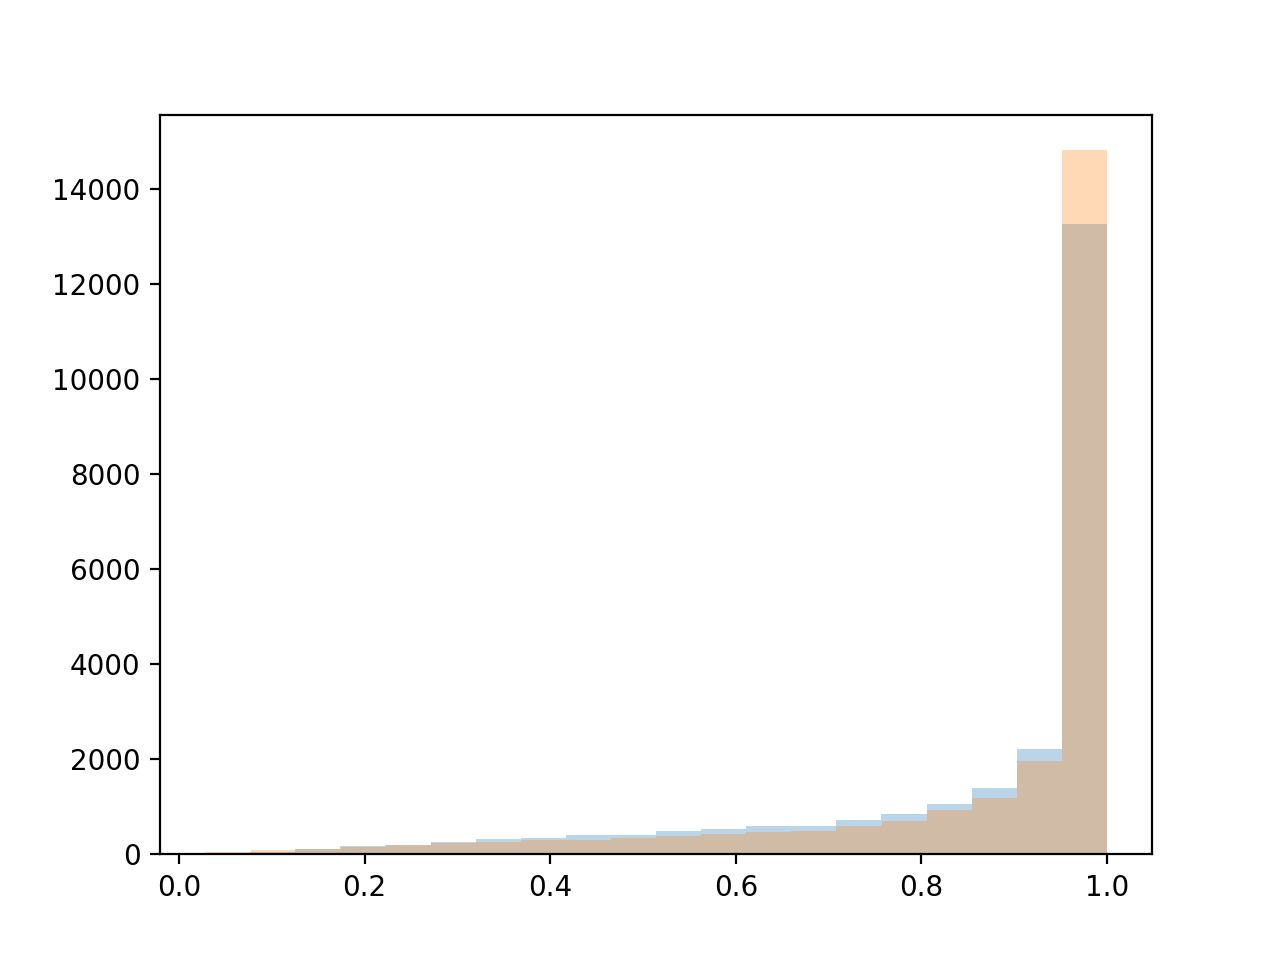

<IPython.core.display.Javascript object>


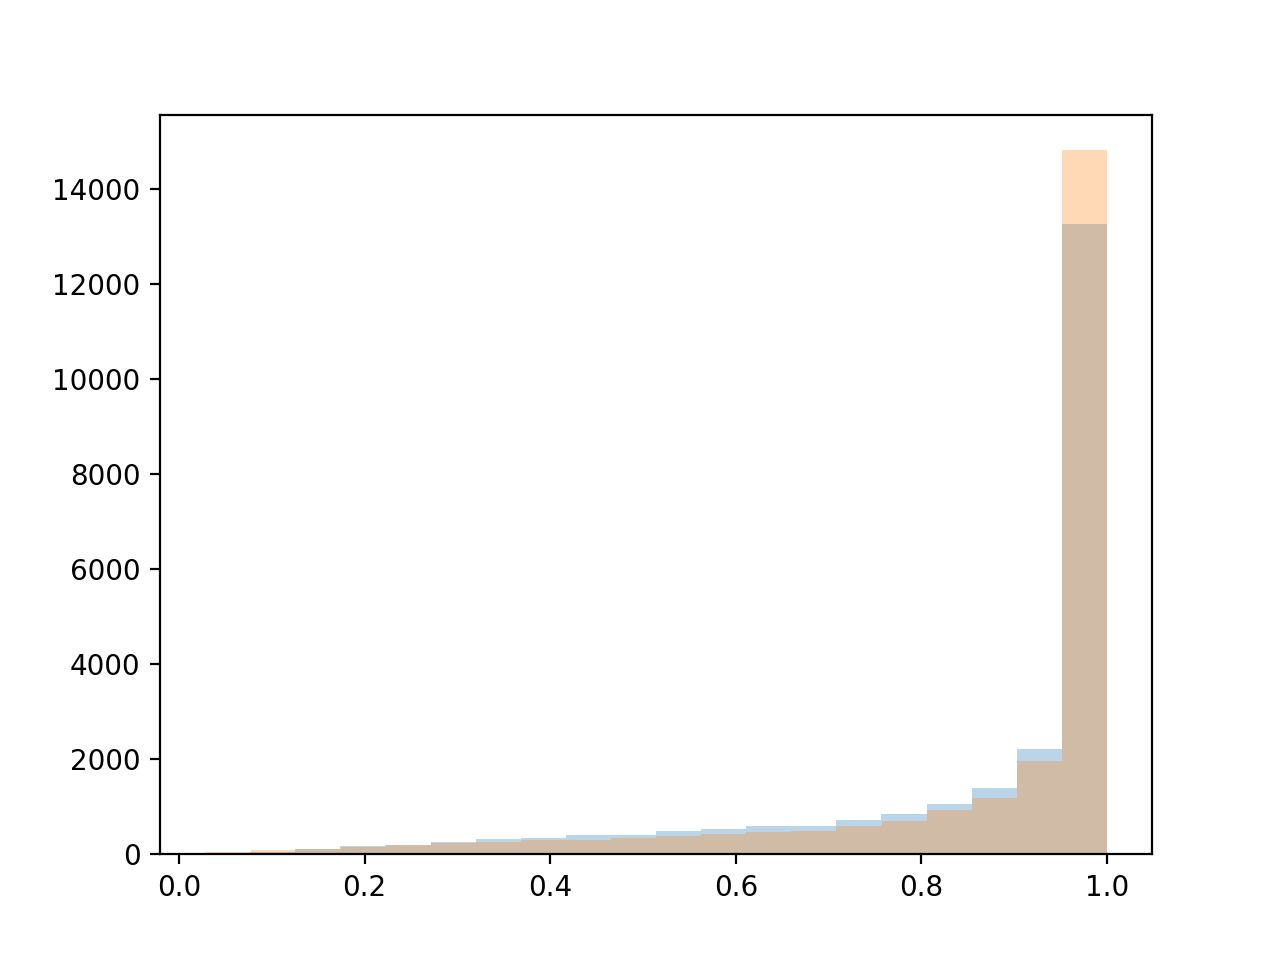

In [65]:
plt.figure()
emba, embb = rank_results[list(rank_results.keys())[ind]]['out'][0]
pd.Series(emba.max(1)).hist(bins=20, grid=False, alpha=0.3)
pd.Series(embb.max(1)).hist(bins=20, grid=False, alpha=0.3) 

<IPython.core.display.Javascript object>


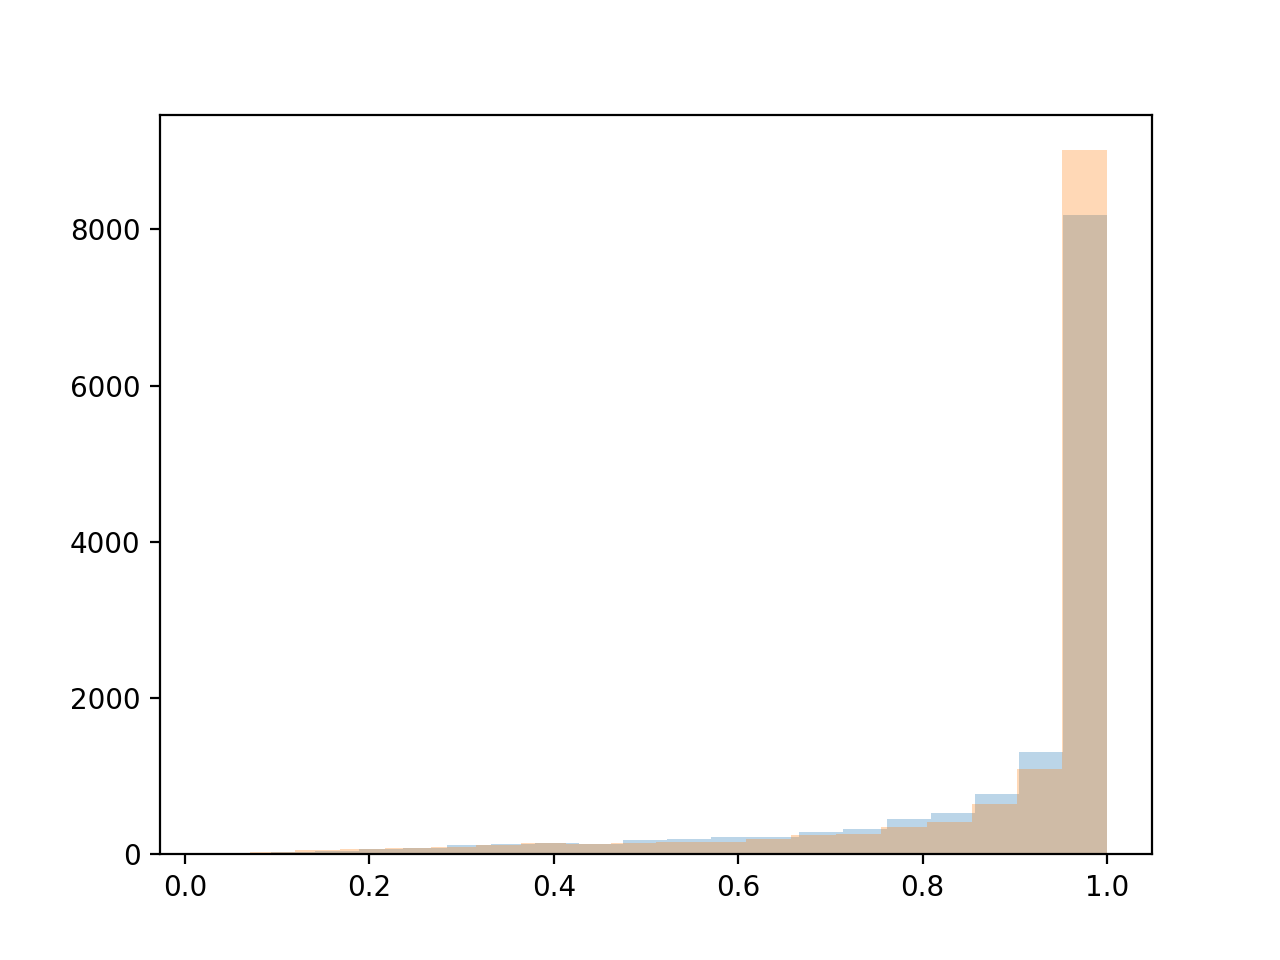

<IPython.core.display.Javascript object>


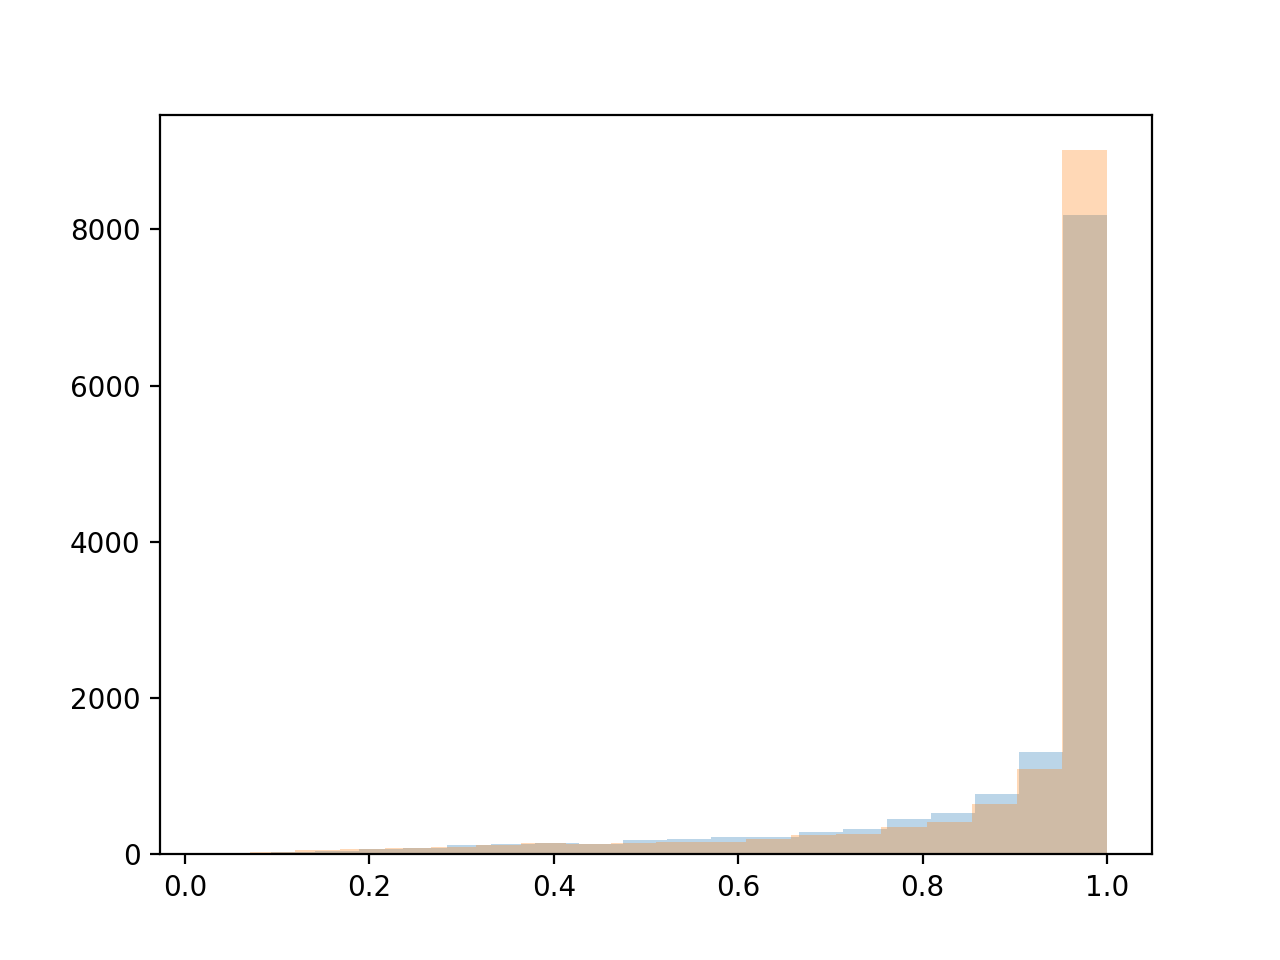

In [66]:
plt.figure()
emba, embb = rank_results[list(rank_results.keys())[ind]]['in_out'][0]
pd.Series(emba.max(1)).hist(bins=20, grid=False, alpha=0.3)
pd.Series(embb.max(1)).hist(bins=20, grid=False, alpha=0.3) 